In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score, classification_report
from sklearn.decomposition import PCA
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('NYPD_Complaint_Data_Historic.csv', low_memory=False)
df.head()
df.shape

(7695047, 35)

In [ ]:
df.columns.values

array(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC',
       'PD_CD', 'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC',
       'JURISDICTION_CODE', 'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA',
       'X_COORD_CD', 'Y_COORD_CD', 'SUSP_AGE_GROUP', 'SUSP_RACE',
       'SUSP_SEX', 'TRANSIT_DISTRICT', 'Latitude', 'Longitude', 'Lat_Lon',
       'PATROL_BORO', 'STATION_NAME', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX'], dtype=object)

In [ ]:
print("Total Number of Observations:", df.shape[0])
print("Total Number of Labels:", df.shape[1])

Total Number of Observations: 7695047
Total Number of Labels: 35


In [ ]:
print("Finding out total null values in each column in the data set:")
df.isnull().sum().sort_values(ascending=False)

Finding out total null values in each column in the data set:


PARKS_NM             7665296
STATION_NAME         7525967
TRANSIT_DISTRICT     7525967
HADEVELOPT           7352862
HOUSING_PSA          7105110
SUSP_AGE_GROUP       4849637
SUSP_SEX             3614477
SUSP_RACE            3481163
CMPLNT_TO_DT         1725606
CMPLNT_TO_TM         1720883
VIC_AGE_GROUP        1638251
LOC_OF_OCCUR_DESC    1594108
PREM_TYP_DESC          41477
OFNS_DESC              18822
Y_COORD_CD             17330
X_COORD_CD             17330
Lat_Lon                17330
Latitude               17330
Longitude              17330
BORO_NM                12418
PATROL_BORO             7158
PD_DESC                 6701
PD_CD                   6701
JURISDICTION_CODE       6701
ADDR_PCT_CD             2166
CMPLNT_FR_DT             655
VIC_RACE                 391
VIC_SEX                  309
CRM_ATPT_CPTD_CD         169
CMPLNT_FR_TM              48
JURIS_DESC                 1
LAW_CAT_CD                 1
KY_CD                      1
RPT_DT                     1
CMPLNT_NUM    

In [ ]:
df.drop(['PARKS_NM','STATION_NAME','TRANSIT_DISTRICT','HADEVELOPT','HOUSING_PSA','PD_CD','JURIS_DESC'], axis = 1, inplace=True)

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(1876805, 28)

In [ ]:
df_trim = df.iloc[:500000]

In [ ]:
#Classification into Felony, Violation, Misdemeanor
df.LAW_CAT_CD.unique()

array(['MISDEMEANOR', 'FELONY', 'VIOLATION'], dtype=object)

In [ ]:
# Granular description of Crime by officers
df.PD_DESC.unique().shape

(381,)

In [ ]:
lec = preprocessing.LabelEncoder()
e = lec.fit_transform(df_trim['LAW_CAT_CD'])
df_trim['encoded'] = e
df_trim

<ipython-input-12-8349ce557149>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trim['encoded'] = e


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_DESC,...,SUSP_RACE,SUSP_SEX,Latitude,Longitude,Lat_Lon,PATROL_BORO,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,encoded
23,441714270,12/06/2019,11:30:00,12/07/2019,08:00:00,10.0,12/19/2019,233.0,SEX CRIMES,"SEXUAL ABUSE 3,2",...,BLACK,M,40.742699,-73.998655,"(40.74269929900004, -73.99865537999993)",PATROL BORO MAN SOUTH,25-44,UNKNOWN,F,1
43,903296937,12/12/2019,00:00:00,12/12/2019,02:19:00,48.0,12/12/2019,104.0,RAPE,RAPE 1,...,BLACK,M,40.843901,-73.900505,"(40.84390125500005, -73.900504632)",PATROL BORO BRONX,<18,BLACK HISPANIC,F,0
48,178126093,12/10/2019,15:00:00,12/10/2019,15:40:00,40.0,12/10/2019,107.0,BURGLARY,"BURGLARY,TRUCK DAY",...,UNKNOWN,U,40.819032,-73.918429,"(40.81903174100006, -73.91842930699994)",PATROL BORO BRONX,UNKNOWN,UNKNOWN,D,0
52,377065402,11/15/2019,15:00:00,11/15/2019,15:15:00,60.0,12/09/2019,578.0,HARRASSMENT 2,"HARASSMENT,SUBD 1,CIVILIAN",...,BLACK,F,40.576930,-73.982110,"(40.57692970800008, -73.98211039599995)",PATROL BORO BKLYN SOUTH,18-24,BLACK,F,2
67,988494161,04/01/1974,00:00:00,08/01/1974,00:00:00,20.0,12/05/2019,104.0,RAPE,RAPE 2,...,WHITE,M,40.784060,-73.975021,"(40.784059874000036, -73.97502051299993)",PATROL BORO MAN NORTH,45-64,WHITE,F,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855381,560641495,02/20/2021,00:35:00,02/20/2021,00:35:00,103.0,02/20/2021,578.0,HARRASSMENT 2,"HARASSMENT,SUBD 1,CIVILIAN",...,WHITE HISPANIC,M,40.710343,-73.787685,"(40.71034319900008, -73.78768527799998)",PATROL BORO QUEENS SOUTH,45-64,WHITE HISPANIC,F,2
855387,123065190,02/22/2021,09:57:00,02/22/2021,10:00:00,76.0,02/22/2021,578.0,HARRASSMENT 2,"HARASSMENT,SUBD 3,4,5",...,WHITE HISPANIC,M,40.674624,-74.003985,"(40.674623610000026, -74.00398505899994)",PATROL BORO BKLYN SOUTH,25-44,WHITE HISPANIC,F,2
855388,371596746,02/23/2021,14:20:00,02/23/2021,14:30:00,84.0,02/24/2021,578.0,HARRASSMENT 2,"HARASSMENT,SUBD 1,CIVILIAN",...,UNKNOWN,U,40.701538,-73.986975,"(40.70153816700008, -73.98697463799994)",PATROL BORO BKLYN NORTH,45-64,WHITE HISPANIC,F,2
855389,662204919,02/28/2021,02:15:00,02/28/2021,02:30:00,7.0,02/28/2021,109.0,GRAND LARCENY,"LARCENY,GRAND BY FALSE PROMISE-IN PERSON CONTACT",...,UNKNOWN,M,40.720200,-73.988735,"(40.72019999600008, -73.98873508199993)",PATROL BORO MAN SOUTH,25-44,WHITE,M,0


In [ ]:
col = ['PD_DESC','LAW_CAT_CD','encoded']
df2 = pd.DataFrame(df_trim[col])

In [ ]:
stemmer = PorterStemmer()
STOPWORD = set(stopwords.words('english'))
INVALID_SIGNS = re.compile('[^0-9a-z #+_]')
SPACE_REPLACE = re.compile('[/(){}\[\]\|@,;]')
NO_REMOVE = re.compile('[\d+]')

def stem_text(text):
    # standardize text
    text = text.lower() 

    # replace symbols with text
    text = SPACE_REPLACE.sub(' ', text) 
    
    # Remove any XXXXX values
    text = text.replace('x', '') 
    
    # Remove whitespaces
    text = NO_REMOVE.sub('', text)

    #  Deleting symbols
    text = INVALID_SIGNS.sub('', text) 

    # Remove StopWords
    text = ' '.join(word for word in text.split() if word not in STOPWORD) 
    
    # Words of length less than 2 or more than 21 are removed
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Word Stemming
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

In [ ]:
df2['PD_DESC'] = df2['PD_DESC'].astype(str)
df2['PD_DESC'] = df2['PD_DESC'].apply(stem_text)
df2['PD_DESC']

23                                         seual abus
43                                               rape
48                                 burglari truck day
52                               harass subd civilian
67                                               rape
                             ...                     
855381                           harass subd civilian
855387                                    harass subd
855388                           harass subd civilian
855389    larceni grand fals promisein person contact
855390                                  aggrav harass
Name: PD_DESC, Length: 500000, dtype: object

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf= True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')
X_train_vc = vectorizer.fit_transform(df2["PD_DESC"])

pd.DataFrame(X_train_vc.toarray(), columns=vectorizer.get_feature_names_out()).head()

,abandon,abandon anim,abus,acc,accessori,accost,accost fraudul,acct,acct compromiseatm,acct compromiseeist,...,violatio,vulner,vulner elderli,weapon,weapon possess,welfar,welfar vulner,worker,worker sleep,ye
0,0.0,0.0,0.581412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


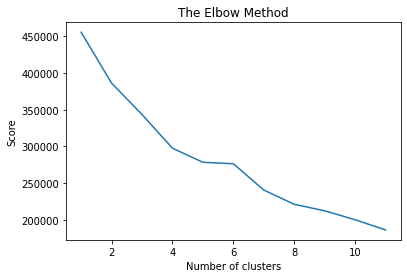

In [ ]:
score = []
for i in range(1,11 + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=43)
    kmeans.fit(X_train_vc)
    score.append(kmeans.inertia_)
plt.plot(range(1,11 + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('elbow.png')
plt.show()

In [ ]:
k_clusters = 3

model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
var = model.fit(X_train_vc)

In [ ]:
category = model.predict(X_train_vc)

In [ ]:
# Create a new column to display the predicted result
df2["Categorized"] = category
df2.head(20)

,PD_DESC,LAW_CAT_CD,encoded,Categorized
23,seual abus,MISDEMEANOR,1,0
43,rape,FELONY,0,0
48,burglari truck day,FELONY,0,0
52,harass subd civilian,VIOLATION,2,2
67,rape,FELONY,0,0
73,assault unclassifi,FELONY,0,1
75,rape,FELONY,0,0
109,harass subd,VIOLATION,2,2
114,rape,FELONY,0,0
116,robberi deliveri person,FELONY,0,0


In [ ]:
acc = len(df2.loc[(df2['encoded'] == df2['Categorized'])])
print('%d were correctly labelled out of %d' %(acc,len(df)))
accuracy_K = accuracy_score(df2['Categorized'],df2['encoded'])
print(accuracy_K)

279300 were correctly labelled out of 1876805
0.5586


In [ ]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X_train_vc.toarray())

NameError: ignored

In [ ]:
colors = ["r", "b", "c", "y", "m" ]

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in category])

for i, txt in enumerate(x):
    ax.annotate(txt, (x_axis[i], y_axis[i]))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df_trim['encoded'],df_trim['PD_DESC'],test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

In [ ]:
Y_train= Y_train.astype(str)
Y_train = vectorizer.transform(Y_train)
Y_train = Y_train.toarray()
Y_test= Y_test.astype(str)
Y_test = vectorizer.transform(Y_test)
Y_test = Y_test.toarray()

In [ ]:
gnb = GaussianNB()
gnb.fit(Y_train,X_train)
X_predict = gnb.predict(Y_test)
accuracy_NB = accuracy_score(X_test,X_predict)
print(accuracy_NB)

In [ ]:
mnb = MultinomialNB()
mnb.fit(Y_train,X_train)
X_predict = mnb.predict(Y_test)
accuracy_MNB = accuracy_score(X_test,X_predict)
print(accuracy_MNB)

In [ ]:
labels = ['K_Means','GaussianNB','MultinomialNB']
values = [accuracy_K,accuracy_NB,accuracy_MNB]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(labels, values, color ='maroon',width = 0.4)
 
plt.xlabel("Algorithm Names")
plt.ylabel("Accuracy Percent")
plt.title("Algorithm Accuracy Comparison")
plt.show()